In [26]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models

In [27]:
epochs = 100
input_size=128
lr =1e-4
Dropout_rate=0.3
batch_size =128

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root ="/root/autodl-tmp/AllAlphaBets"

train_dataset : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(input_size, input_size),
    subset = "training",
    seed = 123,
    validation_split = 0.2
)

valid_dataset : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(input_size, input_size),
    subset="validation",
    seed = 123,
    validation_split=0.2
)
class_names = train_dataset.class_names
num_classes = len(class_names)
train_num_images = len(train_dataset.file_paths)
val_num_images = len(valid_dataset.file_paths)
print(class_names)
print(f"num: {num_classes}")
print(f"train imgs: {train_num_images}")
print(f"val imgs: {val_num_images}")

Found 80883 files belonging to 15 classes.
Using 64707 files for training.
Found 80883 files belonging to 15 classes.
Using 16176 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
num: 15
train imgs: 64707
val imgs: 16176


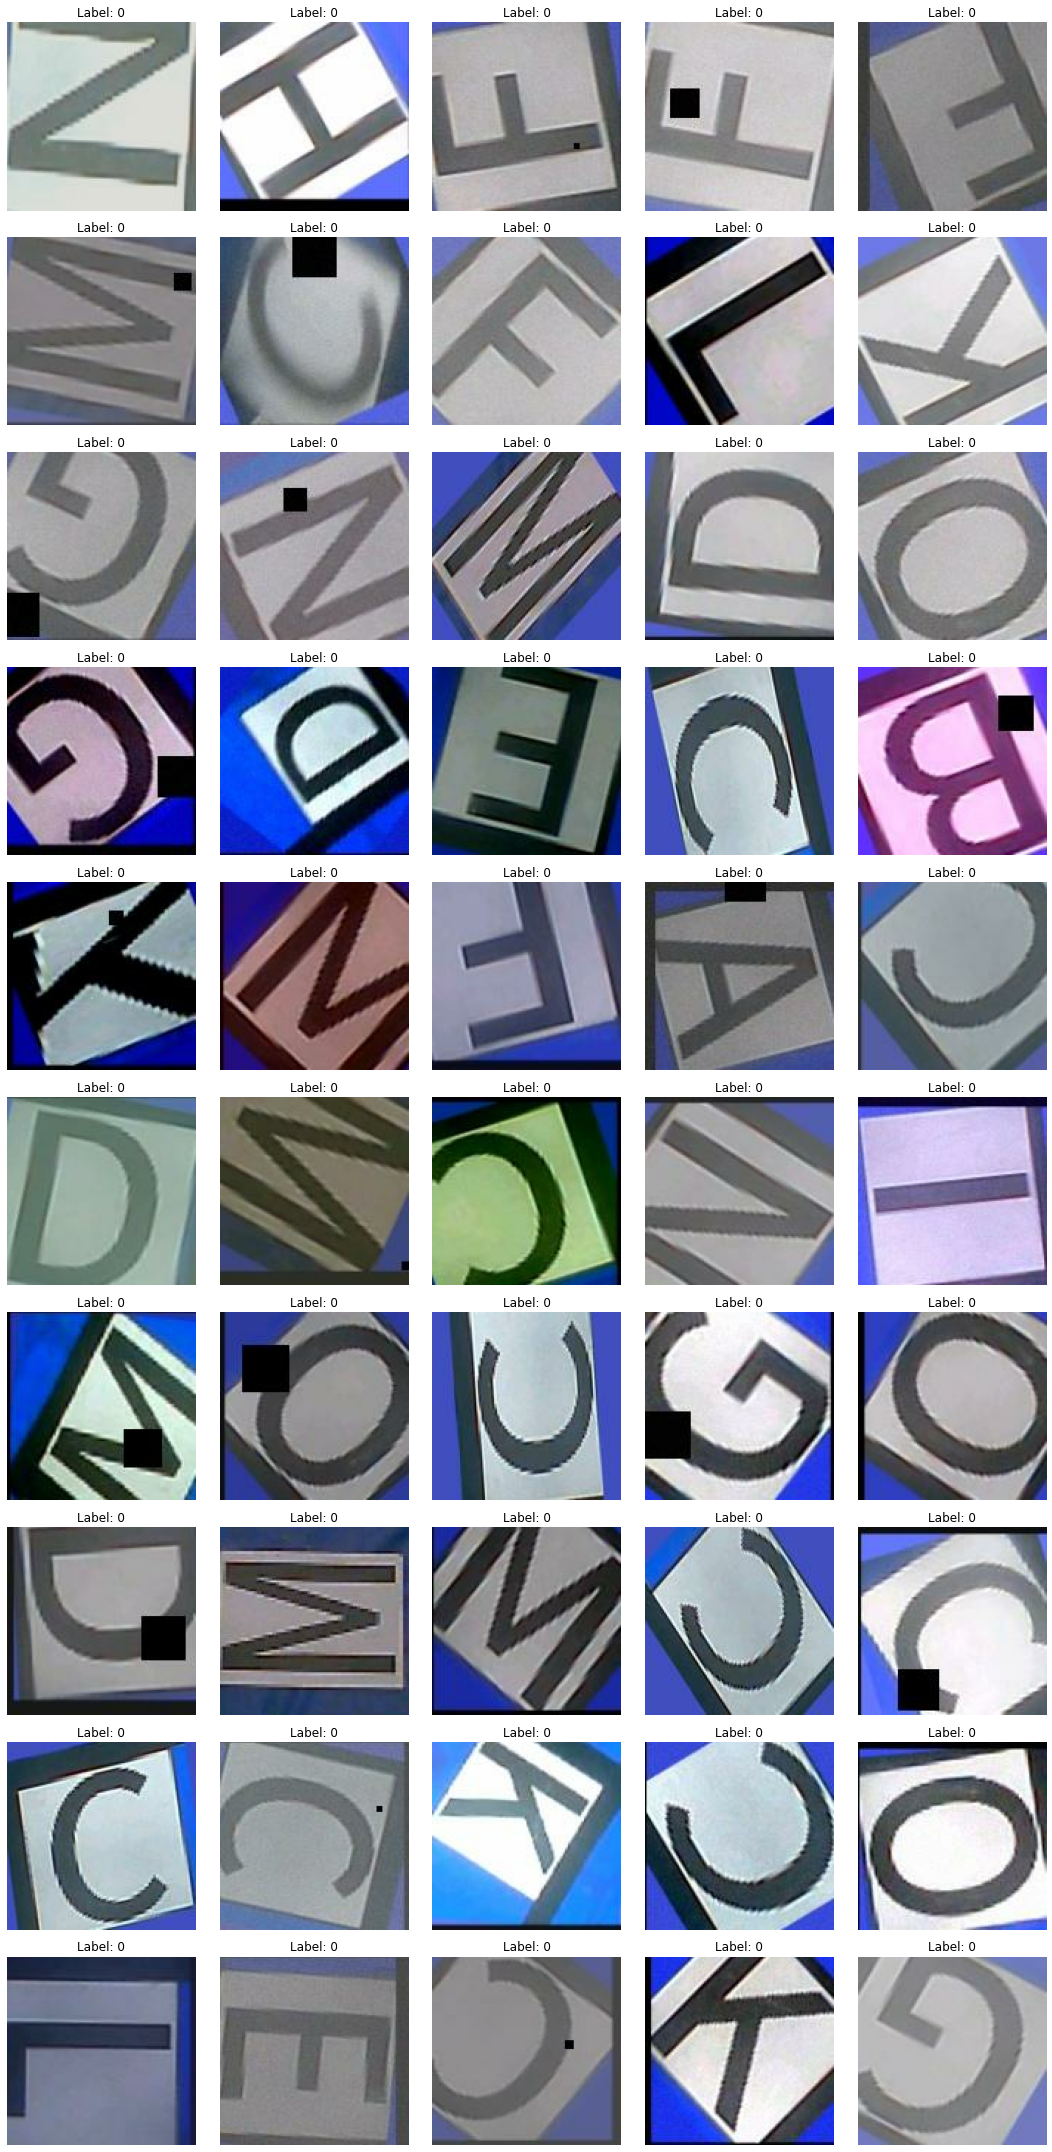

In [50]:
iterator = iter(train_dataset)
images, labels = next(iterator)

# 设置要显示的图像数量和布局
num_images_to_display = 50  # 总共要显示的图像数量
images_per_row = 5          # 每行显示的图像数量
rows = (num_images_to_display + images_per_row - 1) // images_per_row  # 计算行数

plt.figure(figsize=(15, rows * 3))

for i in range(num_images_to_display):
    ax = plt.subplot(rows, images_per_row, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 使用 .numpy() 将 Tensor 转换为 NumPy 数组
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [54]:
def Mobilenet(input_size,weights,Dropout_rate,Trainable,alpha = 0.25):
    base_model = keras.applications.MobileNet(
        input_shape=(input_size, input_size, 3),
        alpha=alpha,
        weights=weights,
        include_top=False
    )
    inputs = keras.Input(shape=(input_size, input_size,3), dtype = tf.float32)
    # scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)# scale_layer(inputs)
    x = base_model(x, training=False)
    if Trainable:
        base_model.trainable =True
    else:
        base_model.trainable = False
        print("特征层已冻结")
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(Dropout_rate, name='Dropout')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [55]:
model = Mobilenet(input_size,weights="imagenet",Dropout_rate=Dropout_rate,Trainable=True)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

2108140/2108140 [==============================] - 7s 4us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_0.25_128 (Functio  (None, 4, 4, 256)        218544    
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 256)              0      

In [56]:
import time
import os
save_path = './alphabets_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop =keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = model.fit(train_dataset, 
                 epochs=epochs,
                 validation_data=valid_dataset,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )


Epoch 1/100
506/506 [==============================] - 31s 57ms/step - loss: 1.1444 - accuracy: 0.6253 - val_loss: 0.2646 - val_accuracy: 0.9309 - lr: 1.0000e-04
Epoch 2/100
506/506 [==============================] - 28s 55ms/step - loss: 0.2748 - accuracy: 0.9112 - val_loss: 0.0969 - val_accuracy: 0.9732 - lr: 1.0000e-04
Epoch 3/100
506/506 [==============================] - 29s 56ms/step - loss: 0.1336 - accuracy: 0.9583 - val_loss: 0.0469 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 4/100
506/506 [==============================] - 28s 56ms/step - loss: 0.0857 - accuracy: 0.9744 - val_loss: 0.0349 - val_accuracy: 0.9891 - lr: 1.0000e-04
Epoch 5/100
506/506 [==============================] - 29s 56ms/step - loss: 0.0449 - accuracy: 0.9874 - val_loss: 0.0236 - val_accuracy: 0.9925 - lr: 1.0000e-04
Epoch 7/100
506/506 [==============================] - 28s 56ms/step - loss: 0.0386 - accuracy: 0.9887 - val_loss: 0.0245 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 8/100
506/506 [=======

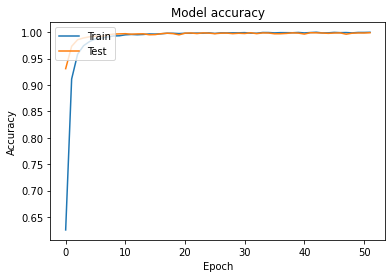

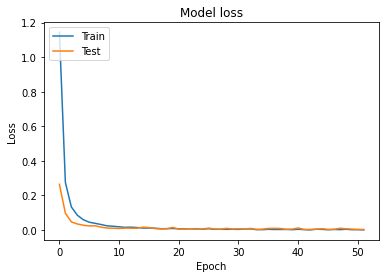

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib
font = {'family': 'SimHei', "size": 24}
matplotlib.rc('font', **font)

def get_confusion_matrix(label,y_pred,cls):
    Confusion_Matrix = confusion_matrix(label, y_pred)
    cls_sum = Confusion_Matrix.sum(axis=0)
    Confusion_Matrix = Confusion_Matrix/cls_sum#归一化
    print(np.around(Confusion_Matrix,3))
    Confusion_Matrix=Confusion_Matrix*255
    plt.matshow(Confusion_Matrix, cmap=plt.cm.Greens)
    plt.xlabel('predict')
    plt.ylabel('true')
    xlocations = np.array(range(len(cls)))
    print(cls)
    print(xlocations)
    plt.xticks(xlocations, cls, rotation=0)
    plt.yticks(xlocations, cls)
    plt.show()

In [60]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def tflite_pre(modelpath,dataset_root,batch_size=128,input_size = 128):
    test_root = dataset_root

    valid_generator = ImageDataGenerator()
    valid_dataset = valid_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_root,
                                                        shuffle=True,
                                                        target_size=(input_size, input_size))
    interpreter = tf.lite.Interpreter(model_path=modelpath)

    input_index = interpreter.get_input_details()
    output_index = interpreter.get_output_details()

    acc=0
    sum=0
    labels=np.array([])
    predictions=np.array([])
    with tqdm(valid_dataset,desc='test_tflite') as d:
        for batch_number, (img, label) in enumerate(d):
            batch = len(label)
            label = label.argmax(axis=1)
            sum += batch
            interpreter.resize_tensor_input(input_index[0]['index'], (batch, input_size, input_size, 3))
            interpreter.resize_tensor_input(output_index[0]['index'], (batch, 15))
            interpreter.allocate_tensors()
            interpreter.set_tensor(input_index[0]['index'], np.array(img, dtype=np.int8))
            interpreter.invoke()
            output = interpreter.get_tensor(output_index[0]['index'])
            output = output.argmax(axis=1)
            correct_pre = np.where(output == label, 1, 0)
            acc += correct_pre.sum()

            predictions =np.append(predictions,output)
            labels=np.append(labels,label)

            if sum >= len(valid_dataset) * batch_size:
                break
            d.set_postfix(acc = acc/sum)
            d.update()
    print("小类准确率：", acc / sum)
    get_confusion_matrix(labels,predictions,valid_dataset.class_indices)
    return acc/sum

In [61]:
from tensorflow.keras.models import load_model
import json
import time
import os
def convert_to_tf_lite(model_path,valid_input_size,valid_path=None, convert_data_path = None):
#     model = load_model(model_path)

#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     converter.post_training_quantize=True
#     tflite_model = converter.convert()
#     model = tf.keras.models.load_model(model_path)
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)

#     # 开启动态量化
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     tflite_model = converter.convert()
    train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
        convert_data_path,
        shuffle = True,
        image_size=(valid_input_size, valid_input_size),
        subset = "validation",
        seed = 123,
        validation_split = 0.2,
    )
    # def representative_dataset():
    #   for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    #     yield [tf.dtypes.cast(data, tf.float32)]
    def representative_data_gen():
        for batch in train_ds.take(500):
            for image in batch[0]:
                # 确认输入形状
                # print(f"Original image shape: {image.shape}")
                reshaped_image = tf.reshape(image, (1, valid_input_size, valid_input_size, 3))
                # print(f"Reshaped image shape: {reshaped_image.shape}")
                yield [reshaped_image]
    model = tf.keras.models.load_model(model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # TFLITE_BUILTINS_INT8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    start_time = time.strftime('%m_%d_%H_%M')
    name = model_path.split('/')[-1][:-3]

    save_root = "./tflite_model/%s_" % start_time +'_' + name
    os.mkdir(save_root)

    save_path = save_root+"/"+str(valid_input_size)+name+'.tflite'

    with open(save_path, 'wb') as f:
        f.write(tflite_model)
    if valid_path!=None:
        acc = tflite_pre(modelpath=save_path,
                         dataset_root=valid_path,
                         input_size=valid_input_size)
        remark = {'model_path':model_path,'input_size':valid_input_size,'valid_path':valid_path,'acc':acc}
        with open(save_root+"/remark.json",'w',encoding='utf-8') as f:
            json.dump(remark,f)

Found 80883 files belonging to 15 classes.
Using 16176 files for validation.


INFO:tensorflow:Assets written to: /tmp/tmpj5k8r4ej/assets


INFO:tensorflow:Assets written to: /tmp/tmpj5k8r4ej/assets
/root/miniconda3/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-08-14 03:17:39.443611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-08-14 03:17:39.443645: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-08-14 03:17:39.444341: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpj5k8r4ej
2024-08-14 03:17:39.459277: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-08-14 03:17:39.459310: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpj5k8r4ej
2024-08-14 03:17:39.510112: I tensorflow/compiler/mlir/mlir_graph_opt

Found 80883 images belonging to 15 classes.


test_tflite: 100%|██████████| 632/632 [03:54<00:00,  2.70it/s, acc=0.625]


小类准确率： 0.6251990470429941
[[0.604 0.    0.    0.003 0.053 0.073 0.    0.    0.    0.    0.107 0.001
  0.034 0.096 0.   ]
 [0.024 0.972 0.024 0.042 0.002 0.002 0.252 0.    0.    0.027 0.009 0.
  0.008 0.    0.   ]
 [0.    0.002 0.704 0.018 0.    0.    0.113 0.    0.    0.001 0.    0.
  0.003 0.    0.007]
 [0.013 0.001 0.045 0.746 0.    0.002 0.085 0.    0.    0.001 0.001 0.
  0.011 0.    0.   ]
 [0.006 0.    0.    0.003 0.46  0.154 0.006 0.    0.    0.    0.001 0.01
  0.023 0.004 0.   ]
 [0.063 0.002 0.002 0.011 0.273 0.584 0.007 0.004 0.001 0.001 0.01  0.025
  0.023 0.007 0.   ]
 [0.    0.    0.033 0.    0.    0.001 0.496 0.    0.    0.    0.    0.
  0.001 0.    0.   ]
 [0.109 0.013 0.001 0.016 0.198 0.118 0.    0.992 0.008 0.    0.167 0.035
  0.025 0.024 0.   ]
 [0.016 0.    0.    0.008 0.001 0.017 0.    0.001 0.991 0.    0.07  0.026
  0.012 0.143 0.   ]
 [0.001 0.01  0.023 0.064 0.002 0.004 0.009 0.    0.    0.968 0.003 0.044
  0.012 0.001 0.   ]
 [0.061 0.    0.    0.031 0.004 0.016

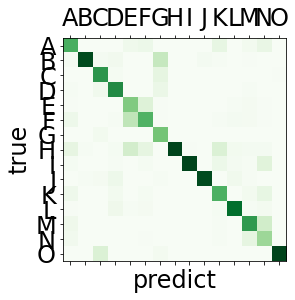

In [62]:
convert_to_tf_lite(model_path='/root/autodl-tmp/17-ai-train-main/alphabets_save/2024_08_14_02_49_21/model_42_0.9989.h5',
                   valid_input_size=input_size,
                   valid_path="/root/autodl-tmp/AllAlphaBets",
                   convert_data_path = "/root/autodl-tmp/AllAlphaBets")